2 / 1000 neutrons transmitted
Fraction of transmission: 0.002


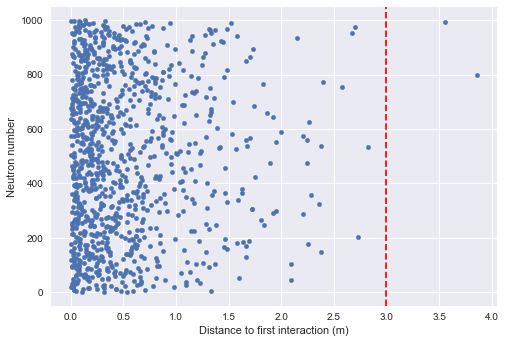

In [232]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')


def neutron_tracking(probability, XS):
    """
    inverse CDF for first interaction

    probability: a number between 0 and 1
    """
    return -np.log(1 - probability)/XS


def neutron_tracking_alt(prob, XS):
    """
    Not the inverse CDF, but since the probabilities are sampled uniformly
    distributed, it doesn't make a difference and abstracts one operation,
    so it's faster.
    Doesn't make a difference here. Only relevant in real Monte Carlo codes
    with millions or billions of neutrons per generation.

    There is a negligible but funny side effect that as written, probabilities
    are sampled in the interval [0, 1). The compliment of this as in the
    original inverse CDF (i.e., 1 - probability) results in a sample in
    the interval of (0, 1]. It means that the original function can't have a
    neutron that doesn't move at all, which makes sense, and includes a neutron
    that moves the whole length, whereas this modified version can have a
    neutron that interacts in the same place it's born and can't move the whole
    length. In practice this should make no difference though ¯\_(ツ)_/¯
    """
    return -np.log(prob)/XS


class ExperimentTransmission:
    def __init__(self, XS, thickness):
        self.XS = XS
        self.thickness = thickness

    def irradiate(self, neutrons, F=neutron_tracking, rng=np.random):
        """
        neutrons: number of neutrons to irradiate with
        F: the inverse CDF function that receives a probability and returns the
            probable length of transmission
        rng: the random number generator function

        first_interaction: distances to first interaction
        transmitted: fraction of neutrons transmitted through the experiment
            given its thickness
        """
        probabilities = rng.random(neutrons)
        first_interaction = F(probabilities, self.XS)
        transmitted_fraction = np.sum(first_interaction > self.thickness)/neutrons
        return first_interaction, transmitted_fraction

    @staticmethod
    def report(transmission, neutrons):
        print(f'{int(transmission*neutrons)} / {neutrons} neutrons transmitted')
        print(f'Fraction of transmission: {transmission}')

    def plot_penetration(self, penetration, s=20):
        fig, ax = plt.subplots()
        ax.scatter(penetration, np.arange(len(penetration)), s=s)
        ax.set(xlabel='Distance to first interaction (m)', ylabel='Neutron number')
        ax.axvline(self.thickness, color='red', linestyle='--')

    def plot_verification(self, penetration, num=50, s=15):
        slab_p = np.linspace(0.001, self.thickness, num=num)
        cells = np.zeros_like(slab_p)

        with np.nditer(cells, op_flags=['readwrite']) as cl:
            for c, p in zip(cl, slab_p):
                c[...] = np.sum(penetration > p)/sample

        I_by_I0 = np.exp(-XS * slab_p)

        fig, ax = plt.subplots()
        ax.scatter(slab_p, cells, s=s, c='k', label='Monte Carlo')
        ax.plot(slab_p, I_by_I0, label='Analytical')
        ax.legend()
        ax.set(xlabel='Distance (m)', ylabel='Neutrons transmitted',
               title='Neutron transmission experiment')


# To have a reproducible sequence, only need to pre-generate the RNG with seed
# and pass to the irradiate method
# rng = np.random.default_rng(42)

XS = 2.0
thickness = 3.0
neutrons = 1000

experiment = ExperimentTransmission(XS, thickness)

first_interaction, transmitted_fraction = experiment.irradiate(neutrons)

experiment.plot_penetration(first_interaction)
experiment.report(transmitted_fraction, neutrons)

In [233]:
samples = neutrons*np.array([2, 4, 8, 16, 32, 64, 128])

for sample in samples:
    first_interaction, transmitted_fraction = experiment.irradiate(sample)
    experiment.report(transmitted_fraction, neutrons)


2 / 1000 neutrons transmitted
Fraction of transmission: 0.0025
2 / 1000 neutrons transmitted
Fraction of transmission: 0.00275
2 / 1000 neutrons transmitted
Fraction of transmission: 0.002875
2 / 1000 neutrons transmitted
Fraction of transmission: 0.0021875
2 / 1000 neutrons transmitted
Fraction of transmission: 0.002625
2 / 1000 neutrons transmitted
Fraction of transmission: 0.002734375
2 / 1000 neutrons transmitted
Fraction of transmission: 0.0026875


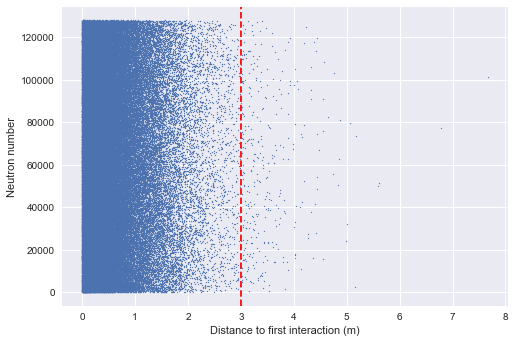

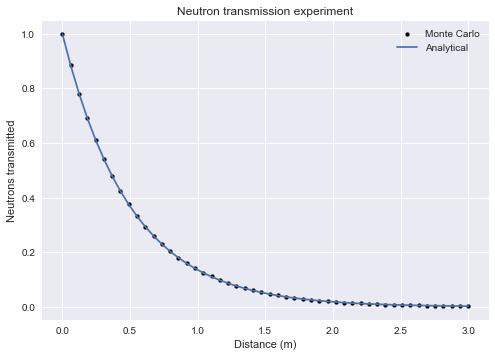

In [234]:
experiment.plot_penetration(first_interaction, s=1)
plt.savefig('Transmission_experiment.pdf')
experiment.plot_verification(first_interaction)
plt.savefig('Transmission_verification.pdf')